# Repeated Measures (Within) Analysis of Variance (ANOVA)

In [1]:
# import libraries 
import numpy as np 
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 16}) 
import savingfigR as sf 
import pingouin as pg 
import pandas as pd 
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats as stats
import cohens_d as cD
from statsmodels.sandbox.stats.multicomp import multipletests

## Four Treatment Group Example

In [2]:
dv = np.array([8,10,7,5,9,9,8,6,7,5,8,4,9,6,5,7,8,7,7,6,5,4,4,3,7,6,5,4,8,8,6,6,9,8,6,5,7,7,4,5])
treatment = np.hstack([[1,2,3,4]*10]) # need to be dummy coded
subject = np.hstack([[1]*4, [2]*4, [3]*4, [4]*4, [5]*4, [6]*4, [7]*4, [8]*4, [9]*4, [10]*4])
df = pd.DataFrame(data=np.vstack((dv, treatment, subject)).T, columns=['dv', 'treatment', 'subject'])

In [3]:
df.head(5)

,dv,treatment,subject
0,8,1,1
1,10,2,1
2,7,3,1
3,5,4,1
4,9,1,2


## Visualize Data

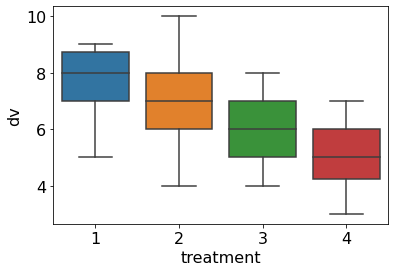

In [4]:
fig = plt.figure()
sns.boxplot(x='treatment', y='dv', data=df)
plt.show()

sf.best_save(fig, 'visData')

## Repeated Measures ANOVA - Univariate Approach

In [5]:
m1 = pg.rm_anova(data=df, dv='dv', subject='subject', within='treatment', detailed=True)
print(m1)

      Source    SS  DF         MS          F     p-unc       np2       eps
0  treatment  38.9   3  12.966667  12.241259  0.000031  0.576296  0.742601
1      Error  28.6  27   1.059259        NaN       NaN       NaN       NaN


## Repeated Measures ANOVA - Greenhouse Geisser

In [6]:
m1_1 = pg.rm_anova(data=df, dv='dv', subject='subject', within='treatment', detailed=True, correction=True)
print(m1_1)

      Source    SS  DF         MS          F     p-unc  p-GG-corr       np2  \
0  treatment  38.9   3  12.966667  12.241259  0.000031   0.000239  0.576296   
1      Error  28.6  27   1.059259        NaN       NaN        NaN       NaN   

        eps sphericity   W-spher   p-spher  
0  0.742601       True  0.346132  0.148839  
1       NaN        NaN       NaN       NaN  


## Organize Data by Treatment

In [7]:
treat1, treat2, treat3, treat4 = dv[0:10], dv[10:20], dv[20:30], dv[30:41]

## Testing normality

In [8]:
stats.shapiro(treat2-treat1) # not sure why none of these are the same 

ShapiroResult(statistic=0.8434712886810303, pvalue=0.048553917557001114)

In [9]:
stats.shapiro(treat3-treat1)

ShapiroResult(statistic=0.8705956935882568, pvalue=0.10157610476016998)

In [10]:
stats.shapiro(treat4-treat1)

ShapiroResult(statistic=0.9252177476882935, pvalue=0.40253207087516785)

In [11]:
stats.shapiro(treat3-treat2)

ShapiroResult(statistic=0.897158682346344, pvalue=0.20385098457336426)

In [12]:
stats.shapiro(treat4-treat2)

ShapiroResult(statistic=0.9433290958404541, pvalue=0.5906160473823547)

In [13]:
stats.shapiro(treat4-treat3)

ShapiroResult(statistic=0.9447940587997437, pvalue=0.6074792742729187)

## Follow up Mean Comparisons

In [14]:
p1v2 = stats.ttest_rel(treat1, treat2, alternative="two-sided")[1] #
p1v3 = stats.ttest_rel(treat1, treat3, alternative="two-sided")[1] #
p1v4 = stats.ttest_rel(treat1, treat4, alternative="two-sided")[1] #
p2v3 = stats.ttest_rel(treat2, treat3, alternative="two-sided")[1] #
p2v4 = stats.ttest_rel(treat2, treat4, alternative="two-sided")[1] #
p3v4 = stats.ttest_rel(treat3, treat4, alternative="two-sided")[1] #
pvals = np.array([p1v2, p1v3, p1v4, p2v3, p2v4, p3v4])
p_adjusted = multipletests(pvals, method='holm')[1][:]
print(p_adjusted)

[1.         0.17759935 0.79952254 0.6395412  1.         1.        ]


## Paired Sample Effect Sizes

In [15]:
cD.cohensd_2paired(treat1, treat2)

0.435924132200985

In [16]:
cD.cohensd_2paired(treat1, treat3)

1.146235419462395

In [17]:
cD.cohensd_2paired(treat1, treat4)

0.6849699322481878

In [18]:
cD.cohensd_2paired(treat2, treat3)

0.7925835078035183

In [19]:
cD.cohensd_2paired(treat2, treat4)

0.2676598420472823

In [20]:
cD.cohensd_2paired(treat3, treat4)

0.5500977908906957

## ANOVA Effect Size in Python

In [21]:
w2p = lambda F, dfErr, dfEff: (F-1) / (F + (dfErr +1)/dfEff)
omega2p = w2p(m1['F'][0], m1['DF'][0], 1) # not correct 
print(f'omega 2 partial = {omega2p:.4f}') 

omega 2 partial = 0.6921


## Power Analysis on ANOVA

In [22]:
pg.power_rm_anova(eta=0.4**2/(1 + 0.4**2), m=4, n=None, power=0.8) # not the same 

9.873104026247905

## Repeated Measures ANOVA - Multivariate Approach

In [23]:
m1m1 = ols('dv ~ 1', data=df).fit()
m1m1_mv = anova_lm(m1m1, typ='III')
print(m1m1_mv) # unsure if this is correct 

           sum_sq    df           F        PR(>F)
Intercept  1664.1   1.0  559.964625  9.637104e-25
Residual    115.9  39.0         NaN           NaN


## Friedman Test

In [24]:
fried = pg.friedman(data=df, dv='dv', within='treatment', subject='subject')
print(fried)

             Source         W  ddof1          Q     p-unc
Friedman  treatment  0.648936      3  19.468085  0.000219


## 2-Way - Univariate Approach

In [25]:
dv1 = np.array([420,420,480,480,600,780,480,480,540,660,780,780,540,660,540,480,660,720,480,480,600,360,720,840,540,600,540,540,720,780])
factorA = np.concatenate(np.hstack([([1]*3, [2]*3)*5]))
factorB = np.hstack([[1,2,3]*10])
subject1 = np.hstack([[1]*6, [2]*6, [3]*6, [4]*6, [5]*6])
df = pd.DataFrame(data=np.vstack((dv1, factorA, factorB, subject1)).T, columns=['dv1', 'factorA', 'factorB', 'subject1'])

In [26]:
df.head(10)

,dv1,factorA,factorB,subject1
0,420,1,1,1
1,420,1,2,1
2,480,1,3,1
3,480,2,1,1
4,600,2,2,1
5,780,2,3,1
6,480,1,1,2
7,480,1,2,2
8,540,1,3,2
9,660,2,1,2


In [27]:
m1 = ols('dv1 ~ factorA*factorB + (subject1/(factorA*factorB))', data=df).fit()
m1_aov = anova_lm(m1)
print(m1_aov) # close but I don't think right 

                            df    sum_sq        mean_sq          F    PR(>F)
factorA                    1.0  147000.0  147000.000000  27.797834  0.000027
factorB                    1.0  131220.0  131220.000000  24.813822  0.000055
factorA:factorB            1.0   64980.0   64980.000000  12.287777  0.001998
subject1                   1.0   11760.0   11760.000000   2.223827  0.150096
subject1:factorA           1.0    8640.0    8640.000000   1.633832  0.214496
subject1:factorB           1.0     810.0     810.000000   0.153172  0.699287
subject1:factorA:factorB   1.0    2250.0    2250.000000   0.425477  0.520974
Residual                  22.0  116340.0    5288.181818        NaN       NaN


## 2-Way - Greenhouse Geisser Corrections

In [28]:
m1_aov = anova_lm(m1, typ='III', robust='hc3') # not sure which robust gives GG correction 
print(m1_aov) # close but I don't think right 

                                 sum_sq    df         F    PR(>F)
Intercept                   9763.114213   1.0  1.846214  0.187993
factorA                      752.766248   1.0  0.142349  0.709572
factorB                      768.083812   1.0  0.145245  0.706777
factorA:factorB             4139.543320   1.0  0.782791  0.385857
subject1                    8125.336615   1.0  1.536509  0.228199
subject1:factorA            4480.228961   1.0  0.847215  0.367325
subject1:factorB            1587.865982   1.0  0.300267  0.589232
subject1:factorA:factorB    1891.117830   1.0  0.357612  0.555942
Residual                  116340.000000  22.0       NaN       NaN


## 2-Way - Multivariate Approach

In [29]:
# i think this is what i've been doing 

## Main Effects of A (Sound)

In [30]:
# sound1 vs sound2 --- group all data sound 1 or sound 2 (ignore effect of light)
sound1 = np.concatenate([dv1[0:3],dv1[6:9],dv1[12:15], dv1[18:21], dv1[24:27]])
sound2 = np.concatenate([dv1[3:6],dv1[9:12],dv1[15:18], dv1[21:24], dv1[27:31]])
stats.ttest_rel(sound1, sound2, alternative = "two-sided")

Ttest_relResult(statistic=-4.06083545780725, pvalue=0.0011682216194768883)

## Main Effects of B (Light)

In [31]:
# light1 vs light2 --- group all data light 1 or light 2 (ignore effect of sound)
light1 = np.array([dv1[0],dv1[3],dv1[6], dv1[9], dv1[12], dv1[15], dv1[18], dv1[21], dv1[24],dv1[27]])
light2 = np.array([dv1[1],dv1[4],dv1[7], dv1[10], dv1[13], dv1[16], dv1[19], dv1[22], dv1[25],dv1[28]])
light3 = np.array([dv1[2],dv1[5],dv1[8], dv1[11], dv1[14], dv1[17], dv1[20], dv1[23], dv1[26],dv1[29]]) # typo on josh's end 
pval_l1vl2 = stats.ttest_rel(light1, light2, alternative = "two-sided")[1]
pval_l1vl3 = stats.ttest_rel(light1, light3, alternative = "two-sided")[1]
pval_l2vl3 = stats.ttest_rel(light2, light3, alternative = "two-sided")[1]
pvals = np.array([pval_l1vl2, pval_l1vl3, pval_l2vl3])
p_adjusted = multipletests(pvals, method='holm')[1][:]
print(p_adjusted) # mine are correct, typo on slide 

[0.02514964 0.02514964 0.12062074]
